In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH="/content/drive/My Drive/J_PHD/OWNDDOS/"
!ls "/content/drive/My Drive/J_PHD/OWNDDOS"

ddosdataset.csv  httpdataset.csv  secondattack.csv
firstattack.csv  normal.csv	  wideattack.csv


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
ddos = pd.read_csv(DATA_PATH+'firstattack.csv')
http = pd.read_csv(DATA_PATH+'httpdataset.csv')

## Data Vizualize

In [ ]:
http.shape

(24324, 7)

In [ ]:
http.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24324 entries, 0 to 24323
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No.          24324 non-null  int64  
 1   Time         24324 non-null  float64
 2   Source       24324 non-null  object 
 3   Destination  24324 non-null  object 
 4   Protocol     24324 non-null  object 
 5   Length       24324 non-null  int64  
 6   Info         24324 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.3+ MB


<AxesSubplot:ylabel='Frequency'>

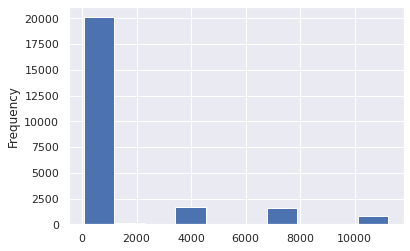

In [ ]:
http['Length'].plot.hist()

In [ ]:
ddos.shape

(162501, 7)

In [ ]:
ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162501 entries, 0 to 162500
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   No.          162501 non-null  int64  
 1   Time         162501 non-null  float64
 2   Source       162501 non-null  object 
 3   Destination  162501 non-null  object 
 4   Protocol     162501 non-null  object 
 5   Length       162501 non-null  int64  
 6   Info         162501 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 8.7+ MB


<AxesSubplot:ylabel='Frequency'>

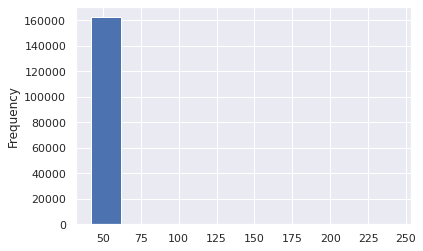

In [ ]:
ddos['Length'].plot.hist()

<AxesSubplot:xlabel='Protocol', ylabel='count'>

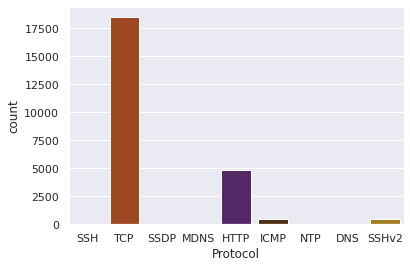

In [ ]:
#protocol=http['Protocol'].unique()
#numbers=http['Protocol'].value_counts()
#plt.bar(protocol,numbers)
label_dict = dict(http.Protocol.value_counts())
sns.set_theme(style="darkgrid")
sns.countplot(http.Protocol, palette="dark")

<AxesSubplot:xlabel='Protocol', ylabel='count'>

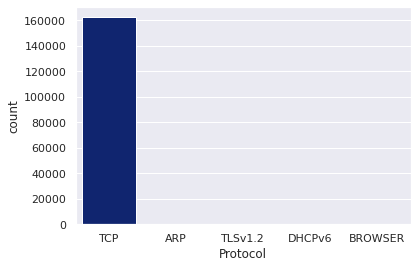

In [ ]:
label_dict = dict(ddos.Protocol.value_counts())
sns.set_theme(style="darkgrid")
sns.countplot(ddos.Protocol, palette="dark")

Text(0.5, 1.0, 'No. of all reqests')

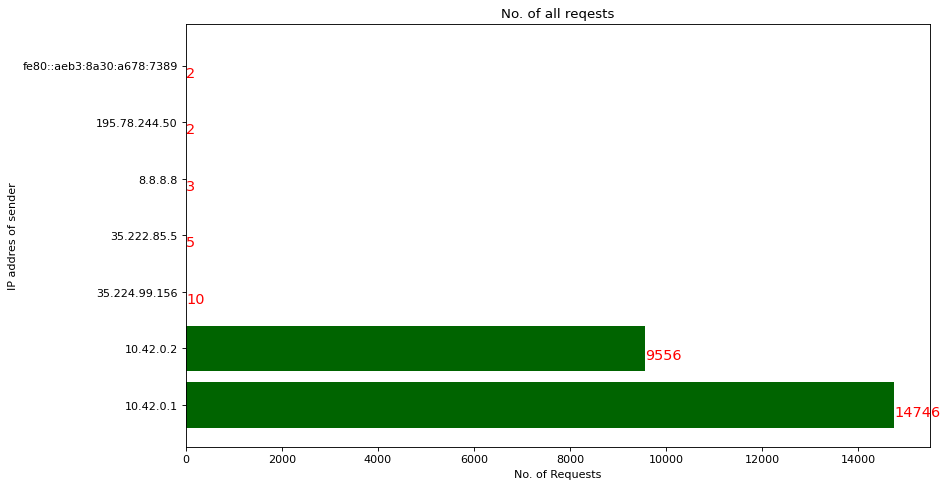

In [ ]:
#source=http['Source'].unique()
#numbers=http['Source'].value_counts()
#plt.bar(source,numbers)
#### Let's look at Oblect columns (Source Destination Protocol)

figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(http.Source.value_counts()).keys()), dict(http.Source.value_counts()).values(), color='darkgreen')

for idx, val in enumerate(dict(http.Source.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

plt.xlabel('No. of Requests')
plt.ylabel('IP addres of sender')
plt.title('No. of all reqests')

Text(0.5, 1.0, 'No. of all reqests')

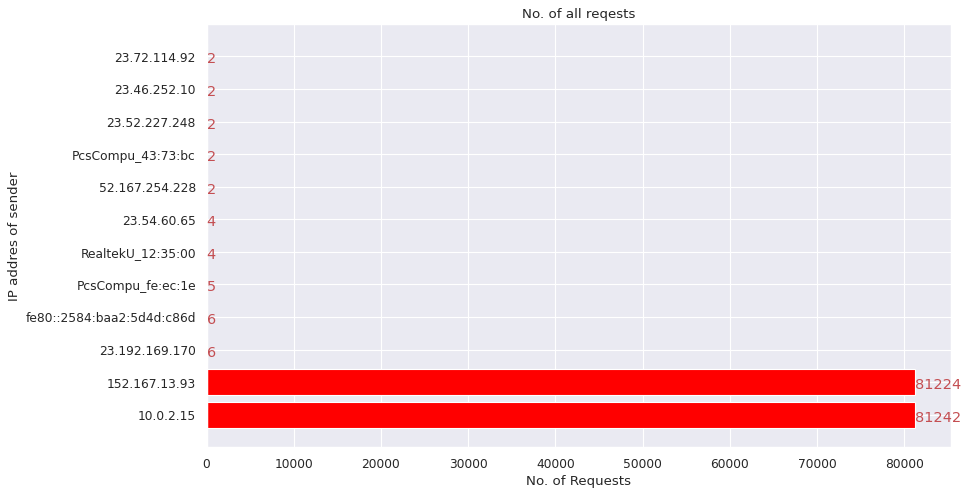

In [ ]:
#source=ddos['Source'].unique()
#numbers=ddos['Source'].value_counts()
#plt.bar(source,numbers)
figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(ddos.Source.value_counts()).keys()), dict(ddos.Source.value_counts()).values(), color='red')

for idx, val in enumerate(dict(ddos.Source.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

plt.xlabel('No. of Requests')
plt.ylabel('IP addres of sender')
plt.title('No. of all reqests')

## Merge  dataset

 **"Class". 1 will mean DDoS attack  
0 will mean normal traffic.**

In [ ]:
ddos['Class'] = 1 # We add a column with 1 as constant value
http['Class'] = 0 # We add a column with 0 as constant value

In [ ]:
dataset = pd.concat([ddos, http], axis=0).reset_index()
dataset.drop('index', 1, inplace=True)

In [ ]:
dataset

,No.,Time,Source,Destination,Protocol,Length,Info,Class
0,1,0.000000,10.0.2.15,52.167.254.228,TCP,54,"49197 > 80 [FIN, ACK] Seq=1 Ack=1 Win=62966 ...",1
1,2,0.002624,52.167.254.228,10.0.2.15,TCP,60,80 > 49197 [ACK] Seq=1 Ack=2 Win=32767 Len=0,1
2,3,0.204789,52.167.254.228,10.0.2.15,TCP,60,"80 > 49197 [FIN, ACK] Seq=1 Ack=2 Win=32767 ...",1
3,4,0.204888,10.0.2.15,52.167.254.228,TCP,54,49197 > 80 [ACK] Seq=2 Ack=2 Win=62966 Len=0,1
4,5,22.343940,PcsCompu_43:73:bc,Broadcast,ARP,60,Who has 10.0.2.1? Tell 10.0.2.5,1
...,...,...,...,...,...,...,...,...
186820,24320,860.774820,10.42.0.2,10.42.0.1,TCP,74,"80 > 53654 [SYN, ACK] Seq=0 Ack=1 Win=28960 ...",0
186821,24321,860.775115,10.42.0.1,10.42.0.2,TCP,66,53654 > 80 [ACK] Seq=1 Ack=1 Win=64256 Len=0...,0
186822,24322,860.775241,10.42.0.1,10.42.0.2,HTTP,256,GET / HTTP/1.1,0
186823,24323,860.775314,10.42.0.2,10.42.0.1,TCP,66,80 > 53654 [ACK] Seq=1 Ack=191 Win=30080 Len...,0


In [ ]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186825 entries, 0 to 186824
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   No.          186825 non-null  int64  
 1   Time         186825 non-null  float64
 2   Source       186825 non-null  object 
 3   Destination  186825 non-null  object 
 4   Protocol     186825 non-null  object 
 5   Length       186825 non-null  int64  
 6   Info         186825 non-null  object 
 7   Class        186825 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 11.4+ MB


### No.

In [ ]:
dataset.drop('No.', 1, inplace=True) # Removing column number

### Time

In [ ]:
dataset["Time"]

0           0.000000
1           0.002624
2           0.204789
3           0.204888
4          22.343940
             ...    
186820    860.774820
186821    860.775115
186822    860.775241
186823    860.775314
186824    860.776418
Name: Time, Length: 186825, dtype: float64

In [ ]:
http['Time'].describe()

count    24324.000000
mean       448.765298
std        238.697554
min          0.000000
25%        241.321312
50%        451.657060
75%        660.599280
max        860.776418
Name: Time, dtype: float64

In [ ]:
ddos['Time'].describe()

count    162501.000000
mean         89.267633
std          37.480834
min           0.000000
25%          57.863098
50%          88.701548
75%         121.951318
max         155.209325
Name: Time, dtype: float64

### Source

In [ ]:
dataset["Source"]

0                 10.0.2.15
1            52.167.254.228
2            52.167.254.228
3                 10.0.2.15
4         PcsCompu_43:73:bc
                ...        
186820            10.42.0.2
186821            10.42.0.1
186822            10.42.0.1
186823            10.42.0.2
186824            10.42.0.2
Name: Source, Length: 186825, dtype: object

In [ ]:
http['Source'].value_counts()

10.42.0.1                    14746
10.42.0.2                     9556
35.224.99.156                   10
35.222.85.5                      5
8.8.8.8                          3
195.78.244.50                    2
fe80::aeb3:8a30:a678:7389        2
Name: Source, dtype: int64

### Destination

In [ ]:
dataset["Destination"]

0         52.167.254.228
1              10.0.2.15
2              10.0.2.15
3         52.167.254.228
4              Broadcast
               ...      
186820         10.42.0.1
186821         10.42.0.2
186822         10.42.0.2
186823         10.42.0.1
186824         10.42.0.1
Name: Destination, Length: 186825, dtype: object

In [ ]:
http['Destination'].value_counts()

10.42.0.2          14652
10.42.0.1           9536
224.0.0.251           62
239.255.255.250       52
35.224.99.156         10
35.222.85.5            5
8.8.8.8                3
195.78.244.50          2
ff02::fb               2
Name: Destination, dtype: int64

In [ ]:
ddos['Destination'].value_counts()

10.0.2.15            81242
152.167.13.93        81223
23.192.169.170           6
ff02::1:2                6
RealtekU_12:35:00        4
PcsCompu_fe:ec:1e        4
23.54.60.65              4
52.167.254.228           2
Broadcast                2
23.52.227.248            2
23.46.252.10             2
23.72.114.92             2
PcsCompu_43:73:bc        1
10.0.2.255               1
Name: Destination, dtype: int64

### Protocol

In [ ]:
dataset["Protocol"]

0          TCP
1          TCP
2          TCP
3          TCP
4          ARP
          ... 
186820     TCP
186821     TCP
186822    HTTP
186823     TCP
186824     TCP
Name: Protocol, Length: 186825, dtype: object

In [ ]:
dataset['Length'].describe()

count    186825.000000
mean        208.109257
std        1050.053021
min          42.000000
25%          54.000000
50%          60.000000
75%          60.000000
max       11239.000000
Name: Length, dtype: float64

### Info

In [ ]:
dataset["Info"]

0         49197  >  80 [FIN, ACK] Seq=1 Ack=1 Win=62966 ...
1            80  >  49197 [ACK] Seq=1 Ack=2 Win=32767 Len=0
2         80  >  49197 [FIN, ACK] Seq=1 Ack=2 Win=32767 ...
3            49197  >  80 [ACK] Seq=2 Ack=2 Win=62966 Len=0
4                           Who has 10.0.2.1? Tell 10.0.2.5
                                ...                        
186820    80  >  53654 [SYN, ACK] Seq=0 Ack=1 Win=28960 ...
186821    53654  >  80 [ACK] Seq=1 Ack=1 Win=64256 Len=0...
186822                                      GET / HTTP/1.1 
186823    80  >  53654 [ACK] Seq=1 Ack=191 Win=30080 Len...
186824    80  >  53654 [ACK] Seq=1 Ack=191 Win=30080 Len...
Name: Info, Length: 186825, dtype: object

In [ ]:
dataset.drop('Info', 1, inplace=True) # Removing column info

### Final columns

In [ ]:
dataset

,Time,Source,Destination,Protocol,Length,Class
0,0.000000,10.0.2.15,52.167.254.228,TCP,54,1
1,0.002624,52.167.254.228,10.0.2.15,TCP,60,1
2,0.204789,52.167.254.228,10.0.2.15,TCP,60,1
3,0.204888,10.0.2.15,52.167.254.228,TCP,54,1
4,22.343940,PcsCompu_43:73:bc,Broadcast,ARP,60,1
...,...,...,...,...,...,...
186820,860.774820,10.42.0.2,10.42.0.1,TCP,74,0
186821,860.775115,10.42.0.1,10.42.0.2,TCP,66,0
186822,860.775241,10.42.0.1,10.42.0.2,HTTP,256,0
186823,860.775314,10.42.0.2,10.42.0.1,TCP,66,0


## One-hot Encoding

### The conversion function

Let's create a function to do this one-hot quickly.

In [ ]:
def mapping(data):
    data = pd.Series(data)

    categories = data.unique()

    dict_cat = {}

    for i in range(len(categories)):
        dict_cat[categories[i]] = i
    return dict_cat

In [ ]:
def one_hot_encode(data, dict_cat):
    data = pd.Series(data)

    one_hot = []
    for el in data:
        one_hot.append(dict_cat[el])

    return to_categorical(one_hot, num_classes=len(dict_cat.keys()))

### Processing of the protocol feature

For the moment, the column "Protocol" is composed of strings.

In [ ]:
dataset['Protocol'].unique()

array(['TCP', 'ARP', 'TLSv1.2', 'DHCPv6', 'BROWSER', 'SSH', 'SSDP',
       'MDNS', 'HTTP', 'ICMP', 'NTP', 'DNS', 'SSHv2'], dtype=object)

As we can see above, it is categorical data with 9 categories. We can thus use one-hot encoding to serialize the values.

In [ ]:
dict_protocol = mapping(dataset['Protocol'])

one_hot_protocol = one_hot_encode(dataset['Protocol'], dict_protocol)

The mapping is the following :

In [ ]:
print(dict_protocol)

{'TCP': 0, 'ARP': 1, 'TLSv1.2': 2, 'DHCPv6': 3, 'BROWSER': 4, 'SSH': 5, 'SSDP': 6, 'MDNS': 7, 'HTTP': 8, 'ICMP': 9, 'NTP': 10, 'DNS': 11, 'SSHv2': 12}


We join the one-hot encoded array of the protocol column. We can then delete the former Protocol column.

In [ ]:
dataset = dataset.join(pd.DataFrame(one_hot_protocol, columns=dict_protocol.keys()))

In [ ]:
dataset.drop("Protocol", 1, inplace=True)

We obtain the following DataFrame :

In [ ]:
dataset

,Time,Source,Destination,Length,Class,TCP,ARP,TLSv1.2,DHCPv6,BROWSER,SSH,SSDP,MDNS,HTTP,ICMP,NTP,DNS,SSHv2
0,0.000000,10.0.2.15,52.167.254.228,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002624,52.167.254.228,10.0.2.15,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.204789,52.167.254.228,10.0.2.15,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.204888,10.0.2.15,52.167.254.228,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.343940,PcsCompu_43:73:bc,Broadcast,60,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186820,860.774820,10.42.0.2,10.42.0.1,74,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186821,860.775115,10.42.0.1,10.42.0.2,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186822,860.775241,10.42.0.1,10.42.0.2,256,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
186823,860.775314,10.42.0.2,10.42.0.1,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Validation set

To check any overfitting pattern in our models, we need to import our own sets. Doing this, we will validate our models on brand new data. However, we need to apply the same processing as above to this dataset.

In [ ]:
att = pd.read_csv(DATA_PATH+'secondattack.csv')
normal = pd.read_csv(DATA_PATH+'normal.csv')
att['Class'] = 1
normal["Class"] = 0

In [ ]:
val_dataset = pd.concat([att, normal], axis=0).reset_index()
val_dataset.drop('index', 1, inplace=True)

In [ ]:
val_dataset

,No.,Time,Source,Destination,Protocol,Length,Info,Class
0,1,0.000000,fe80::2584:baa2:5d4d:c86d,ff02::1:2,DHCPv6,152,Solicit XID: 0xd0f8ae CID: 0001000121e8031c080...,1
1,2,32.019548,fe80::2584:baa2:5d4d:c86d,ff02::1:2,DHCPv6,152,Solicit XID: 0xd0f8ae CID: 0001000121e8031c080...,1
2,3,227.921904,PcsCompu_43:73:bc,Broadcast,ARP,60,Who has 10.0.2.15? Tell 10.0.2.5,1
3,4,227.922218,PcsCompu_fe:ec:1e,PcsCompu_43:73:bc,ARP,42,10.0.2.15 is at 08:00:27:fe:ec:1e,1
4,5,227.998806,142.7.230.241,10.0.2.15,TCP,60,27573 > 80 [SYN] Seq=0 Win=2493 Len=0,1
...,...,...,...,...,...,...,...,...
66717,17017,266.981299,20.42.65.85,10.0.2.15,TCP,60,[TCP Keep-Alive ACK] 443 > 49315 [ACK] Seq=6...,0
66718,17018,268.253266,54.92.160.104,10.0.2.15,TCP,60,"11103 > 49298 [FIN, ACK] Seq=6518 Ack=2853 W...",0
66719,17019,268.253370,10.0.2.15,54.92.160.104,TCP,54,49298 > 11103 [ACK] Seq=2853 Ack=6519 Win=63...,0
66720,17020,269.384607,10.0.2.15,18.195.152.201,TCP,55,[TCP Keep-Alive] 49288 > 443 [ACK] Seq=2064 ...,0


In [ ]:
corr = val_dataset.corr("pearson")
corr.style.background_gradient(cmap='YlGnBu').set_precision(2)

,No.,Time,Length,Class
No.,1.00,0.64,-0.34,0.49
Time,0.64,1.00,-0.54,0.80
Length,-0.34,-0.54,1.00,-0.72
Class,0.49,0.80,-0.72,1.00


In [ ]:
val_dataset.drop('No.', 1, inplace=True) # Removing column number
val_dataset.drop('Info', 1, inplace=True) # Removing column info

In [ ]:
val_dataset = val_dataset[val_dataset.Protocol.isin(dict_protocol.keys())] # Removal of outliers

one_hot_protocol = one_hot_encode(val_dataset['Protocol'], dict_protocol)

In [ ]:
val_dataset

,Time,Source,Destination,Protocol,Length,Class
0,0.000000,fe80::2584:baa2:5d4d:c86d,ff02::1:2,DHCPv6,152,1
1,32.019548,fe80::2584:baa2:5d4d:c86d,ff02::1:2,DHCPv6,152,1
2,227.921904,PcsCompu_43:73:bc,Broadcast,ARP,60,1
3,227.922218,PcsCompu_fe:ec:1e,PcsCompu_43:73:bc,ARP,42,1
4,227.998806,142.7.230.241,10.0.2.15,TCP,60,1
...,...,...,...,...,...,...
66717,266.981299,20.42.65.85,10.0.2.15,TCP,60,0
66718,268.253266,54.92.160.104,10.0.2.15,TCP,60,0
66719,268.253370,10.0.2.15,54.92.160.104,TCP,54,0
66720,269.384607,10.0.2.15,18.195.152.201,TCP,55,0


In [ ]:
val_dataset = val_dataset.join(pd.DataFrame(one_hot_protocol, columns=dict_protocol.keys()))

In [ ]:
val_dataset.dropna(inplace=True)
val_dataset = val_dataset.drop("Protocol", 1)

In [ ]:
val_dataset

,Time,Source,Destination,Length,Class,TCP,ARP,TLSv1.2,DHCPv6,BROWSER,SSH,SSDP,MDNS,HTTP,ICMP,NTP,DNS,SSHv2
0,0.000000,fe80::2584:baa2:5d4d:c86d,ff02::1:2,152,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32.019548,fe80::2584:baa2:5d4d:c86d,ff02::1:2,152,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,227.921904,PcsCompu_43:73:bc,Broadcast,60,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,227.922218,PcsCompu_fe:ec:1e,PcsCompu_43:73:bc,42,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,227.998806,142.7.230.241,10.0.2.15,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63882,210.223758,10.0.2.15,23.33.27.66,54,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63883,210.229013,10.0.2.15,23.33.27.66,54,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63884,210.239689,23.33.27.66,10.0.2.15,1514,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63885,210.239689,23.33.27.66,10.0.2.15,1514,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
corr = val_dataset.corr("pearson")
corr.style.background_gradient(cmap='BuGn').set_precision(2)

,Time,Length,Class,TCP,ARP,TLSv1.2,DHCPv6,BROWSER,SSH,SSDP,MDNS,HTTP,ICMP,NTP,DNS,SSHv2
Time,1.00,-0.63,0.88,0.42,0.00,-0.40,-0.00,-0.02,nan,-0.03,-0.02,-0.02,-0.00,nan,-0.11,nan
Length,-0.63,1.00,-0.73,-0.29,-0.01,0.27,-0.00,0.00,nan,0.02,0.04,0.04,0.01,nan,0.09,nan
Class,0.88,-0.73,1.00,0.39,0.00,-0.37,0.01,-0.01,nan,-0.02,-0.03,-0.05,-0.01,nan,-0.11,nan
TCP,0.42,-0.29,0.39,1.00,-0.08,-0.93,-0.07,-0.04,nan,-0.12,-0.08,-0.13,-0.02,nan,-0.28,nan
ARP,0.00,-0.01,0.00,-0.08,1.00,-0.00,-0.00,-0.00,nan,-0.00,-0.00,-0.00,-0.00,nan,-0.00,nan
TLSv1.2,-0.40,0.27,-0.37,-0.93,-0.00,1.00,-0.00,-0.00,nan,-0.00,-0.00,-0.00,-0.00,nan,-0.01,nan
DHCPv6,-0.00,-0.00,0.01,-0.07,-0.00,-0.00,1.00,-0.00,nan,-0.00,-0.00,-0.00,-0.00,nan,-0.00,nan
BROWSER,-0.02,0.00,-0.01,-0.04,-0.00,-0.00,-0.00,1.00,nan,-0.00,-0.00,-0.00,-0.00,nan,-0.00,nan
SSH,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SSDP,-0.03,0.02,-0.02,-0.12,-0.00,-0.00,-0.00,-0.00,nan,1.00,-0.00,-0.00,-0.00,nan,-0.00,nan


## 1 - First Models

The columns Source and Destination are for the moment hard to use. Indeed, if we just one-hot encode them, there will be a huge overfitting as the DDoS dataset has an unique source IP and same for destination IP.

In [ ]:
final = dataset.drop(['Source', 'Destination'], 1).copy()

In [ ]:
col_order = list(final.columns.values)

In [ ]:
final = final[col_order]

In [ ]:
val_final = val_dataset.drop(['Source', 'Destination'], 1).copy()

In [ ]:
val_final = val_final[col_order]

For this first model, we will not use the IP. We will introduce them when we will use a sliding-window based model.

In [ ]:
final

,Time,Length,Class,TCP,ARP,TLSv1.2,DHCPv6,BROWSER,SSH,SSDP,MDNS,HTTP,ICMP,NTP,DNS,SSHv2
0,0.000000,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002624,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.204789,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.204888,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.343940,60,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186820,860.774820,74,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186821,860.775115,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186822,860.775241,256,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
186823,860.775314,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
val_final

,Time,Length,Class,TCP,ARP,TLSv1.2,DHCPv6,BROWSER,SSH,SSDP,MDNS,HTTP,ICMP,NTP,DNS,SSHv2
0,0.000000,152,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32.019548,152,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,227.921904,60,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,227.922218,42,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,227.998806,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63882,210.223758,54,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63883,210.229013,54,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63884,210.239689,1514,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63885,210.239689,1514,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train = final.drop('Class', 1).to_numpy()

dict_y = mapping(final['Class'])

y_train = one_hot_encode(final['Class'], dict_y)

In [ ]:
X_test = val_final.drop('Class', 1).to_numpy()

y_test = one_hot_encode(val_final['Class'], dict_y)

In [ ]:
import matplotlib.pyplot as plt
def show_acc(history, val = False):
    acc = history.history['acc']

    loss = history.history['loss']
    print("Train accuracy :", history.history['acc'][-1])

    if val:
        val_acc = history.history['val_acc']
        val_loss = history.history['val_loss']
        print("Test accuracy  :", history.history['val_acc'][-1])

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'g', label='Training acc')
    if val:
        plt.plot(epochs, val_acc, 'r', label='Testing acc')
        plt.title('Training and testing accuracy')
    else:
        plt.title('Training accuracy')

    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'g', label='Training loss')

    if val:

        plt.plot(epochs, val_loss, 'r', label='Testing loss')
        plt.title('Training and test loss')
    else:
        plt.title("Training loss")
    plt.legend()

    plt.show()

### Model 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
model = Sequential()

model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')

In [ ]:
#Display binary confusion matrix using Seaborn heatmap
def confusion_plot(matrix, labels=None):
    labels = labels if labels else ['Negative (0)', 'Positive (1)']

    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='GnBu', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()

    return fig

In [ ]:
history = model.fit(X_train, y_train,  validation_data=(X_test, y_test), batch_size=200, epochs= 50, verbose=0)

Train accuracy : 0.999903678894043
Test accuracy  : 0.160485178232193


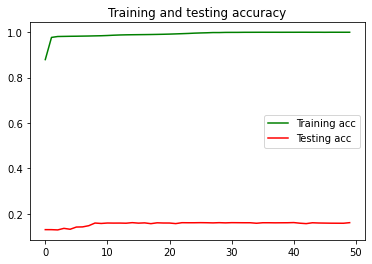

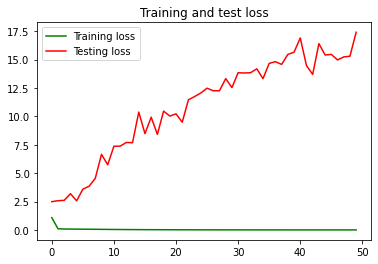

In [ ]:
show_acc(history, val=True)

In [ ]:
model.evaluate(X_test, y_test, batch_size=200)

308/308 [==============================] - 0s 927us/step - loss: 17.4138 - acc: 0.1605


[17.413848876953125, 0.160485178232193]

In [ ]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

1920/1920 [==============================] - 2s 1ms/step


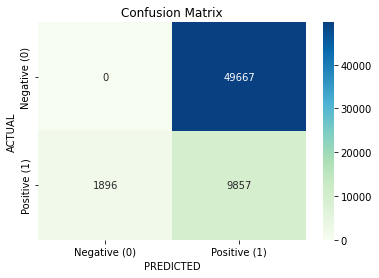

In [ ]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

confusion_plot(confusion_matrix(y_true, y_pred))

In [ ]:
balanced_accuracy_score(y_true, y_pred)

0.4193397430443291

### Model 2

In [ ]:
model = Sequential()

model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')

In [ ]:
history = model.fit(X_train, y_train,  validation_data=(X_test, y_test), batch_size=200, epochs= 20, verbose=0)

Train accuracy : 0.9842526316642761
Test accuracy  : 0.16024096310138702


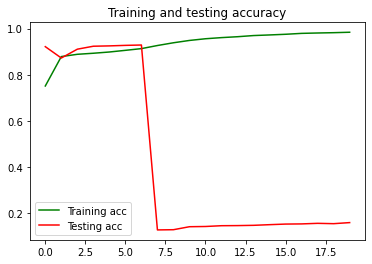

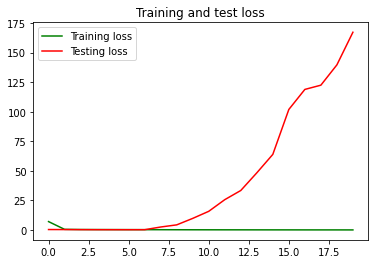

In [ ]:
show_acc(history, val=True)

In [ ]:
model.evaluate(X_test, y_test, batch_size=200)

308/308 [==============================] - 0s 976us/step - loss: 167.2607 - acc: 0.1602


[167.26065063476562, 0.16024096310138702]

In [ ]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

1920/1920 [==============================] - 2s 967us/step


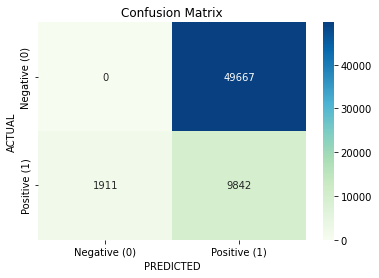

In [ ]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

confusion_plot(confusion_matrix(y_true, y_pred))

In [ ]:
balanced_accuracy_score(y_true, y_pred)

0.4187016081000596

In [ ]:
dataset

,Time,Source,Destination,Length,Class,TCP,ARP,TLSv1.2,DHCPv6,BROWSER,SSH,SSDP,MDNS,HTTP,ICMP,NTP,DNS,SSHv2
0,0.000000,10.0.2.15,52.167.254.228,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002624,52.167.254.228,10.0.2.15,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.204789,52.167.254.228,10.0.2.15,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.204888,10.0.2.15,52.167.254.228,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.343940,PcsCompu_43:73:bc,Broadcast,60,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186820,860.774820,10.42.0.2,10.42.0.1,74,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186821,860.775115,10.42.0.1,10.42.0.2,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186822,860.775241,10.42.0.1,10.42.0.2,256,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
186823,860.775314,10.42.0.2,10.42.0.1,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def windows_process(data, window_len = 5):

    data = np.array(data)
    windows = []
    classes = []
    for i in range(len(data) - window_len):
        window = []
        for j in range(window_len):
            window.append(data[i+j])
        class_name = window[0][4]
        classes.append(class_name)
        windows.append(window)
    windows = np.array(windows)
    classes = np.array(classes)
    return windows, classes

In [ ]:
test = dataset[:30]
print("From a shape of", test.to_numpy().shape)
print("To a shape of", windows_process(test)[0].shape)

From a shape of (30, 18)
To a shape of (25, 5, 18)


In [ ]:
def normalize_time(window):
    start_time = window[0][0]
    for i in range(len(window)):
        window[i][0] = window[i][0] - start_time

    return window

### Introducing IPs

We have to use IPs in a special way. Indeed, if we do a simple one hot encoding on the whole dataset, there will be overfitting as a DDoS comes from a certain IP. What we are going to do is to do a one hot encoding of the IPs inside the windows to detect IP repetitions.

In [ ]:
def IP_process(window):
    dict_ip = mapping(window[:,1:3].flatten())

    for i in range(len(window)):
        window[i][1] = dict_ip[ window[i][1]]
        window[i][2] = dict_ip[ window[i][2]]

    return window

In [ ]:
time_dataset, classes = windows_process(dataset)

In [ ]:
dataset

,Time,Source,Destination,Length,Class,TCP,ARP,TLSv1.2,DHCPv6,BROWSER,SSH,SSDP,MDNS,HTTP,ICMP,NTP,DNS,SSHv2
0,0.000000,10.0.2.15,52.167.254.228,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002624,52.167.254.228,10.0.2.15,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.204789,52.167.254.228,10.0.2.15,60,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.204888,10.0.2.15,52.167.254.228,54,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.343940,PcsCompu_43:73:bc,Broadcast,60,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186820,860.774820,10.42.0.2,10.42.0.1,74,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186821,860.775115,10.42.0.1,10.42.0.2,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186822,860.775241,10.42.0.1,10.42.0.2,256,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
186823,860.775314,10.42.0.2,10.42.0.1,66,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
time_dataset_test, classes_test = windows_process(val_dataset)

In [ ]:
for i in range(len(time_dataset)):
    time_dataset[i] = normalize_time(time_dataset[i])
    time_dataset[i] = IP_process(time_dataset[i])

In [ ]:
for i in range(len(time_dataset_test)):
    time_dataset_test[i] = normalize_time(time_dataset_test[i])
    time_dataset_test[i] = IP_process(time_dataset_test[i])

### Model

In [ ]:
time_dataset =  np.asarray(time_dataset).astype('float32')

dict_y = mapping(classes)

y_train = one_hot_encode(classes, dict_y)

In [ ]:
time_dataset_test =  np.asarray(time_dataset_test).astype('float32')

y_test = one_hot_encode(classes_test, dict_y)

In [ ]:
from tensorflow.keras import regularizers
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

model.add(MaxPooling1D(pool_size=2))

model.add(layers.Normalization())

model.add(layers.LSTM(2, return_sequences=True))
model.add(layers.Flatten())

model.add(layers.Dense(4,activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)))

model.add(layers.Dropout(.2))
model.add(layers.Dense(8,activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)))


model.add(layers.Dropout(.2))
model.add(layers.Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


history = model.fit(time_dataset, y_train, validation_data=(time_dataset_test, y_test), epochs = 50, batch_size=500, verbose=1)

Epoch 1/50
374/374 [==============================] - 7s 6ms/step - loss: 0.4933 - acc: 0.8491 - val_loss: 0.4779 - val_acc: 0.8087
Epoch 2/50
374/374 [==============================] - 2s 5ms/step - loss: 0.4014 - acc: 0.8698 - val_loss: 0.4655 - val_acc: 0.8087
Epoch 3/50
374/374 [==============================] - 2s 5ms/step - loss: 0.3386 - acc: 0.8698 - val_loss: 0.2328 - val_acc: 0.8087
Epoch 4/50
374/374 [==============================] - 2s 5ms/step - loss: 0.1383 - acc: 0.8698 - val_loss: 0.2203 - val_acc: 0.8087
Epoch 5/50
374/374 [==============================] - 2s 5ms/step - loss: 0.1191 - acc: 0.9300 - val_loss: 0.2101 - val_acc: 0.9654
Epoch 6/50
374/374 [==============================] - 2s 6ms/step - loss: 0.1099 - acc: 0.9636 - val_loss: 0.1914 - val_acc: 0.9705
Epoch 7/50
374/374 [==============================] - 2s 5ms/step - loss: 0.1032 - acc: 0.9633 - val_loss: 0.1766 - val_acc: 0.9745
Epoch 8/50
374/374 [==============================] - 2s 5ms/step - loss: 0.

Train accuracy : 0.9927952289581299
Test accuracy  : 0.9997720718383789


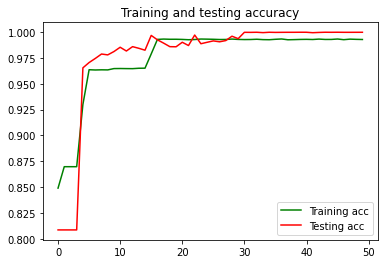

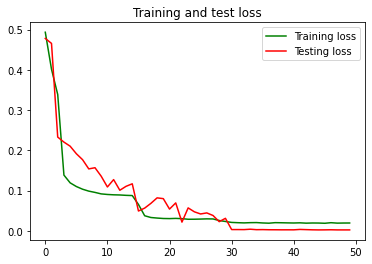

In [ ]:
show_acc(history, val=True)

In [ ]:
y_pred = model.predict(time_dataset_test)
y_pred=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

1920/1920 [==============================] - 3s 2ms/step


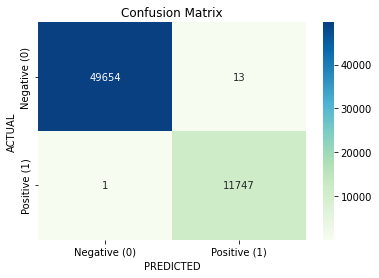

In [ ]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

confusion_plot(confusion_matrix(y_true, y_pred))

In [ ]:
balanced_accuracy_score(y_true, y_pred)

0.9998265679592926

In [ ]:
model.save("model.h5")